<div style="background-color:lightblue; padding:10px;">
    
# Predicting Coronary Heart Disease Modeling Approach

- The goal is to predict coronary heart disease with three models and comparing their performance using R-Squared Error, Mean Square Error (MSE), and Mean Absolute Error (MAE).

- There are 54 potential features to predict coronary heart disease. 

- The data was split into train and test data so that the training set contained 80% of the available data from each set. 

- The train-test-split at the state level was aggregrated to a train-test-split at the continential level. 

- ___ALL MODEL ASSUMPTION___: We exculded data from the US territories, including the `Virgin Islands`, Puerto Rico, and also Hawaii, Alaska, Delaware, and Washington DC. There were very few data points for each location with many empty values. 

## Model 1 - XGBoost

    - Modeling assumptions: NONE

## Model 2 - Gaussian Naive Bayes

    - Modeling Assumption #1: The heart disease data was discretized into 10 bins given the range of values in the data column. 
    - Modeling Assumption #2: All available features were used in the model, so no attention was given to selecting uncorrelated features.

## Model 3 - Linear Regression

    - Modeling Assumption #1: Use LassoCV to select the most important uncorrelated features. 
    - Modeling Assumption #2: A standard scalar was used to scale the feature data. 
    - Modeling Assumption #3: Any missing value in the data was marked with -1. To do linear regression, data was imputed with the mean value for that column.   
    
</div>    

### Import Data and Exclude Territories

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
US = pd.read_csv("../PCD_local/gis_data.csv")

In [3]:
import re

# Regular expression to extract the state abbreviation
state_extraction_regex = r'\(([A-Z]{2})\)'

# Extracting state abbreviation and create a new column for it
US['State'] = US.iloc[:, 1].apply(lambda x: re.search(state_extraction_regex, x).group(1) if re.search(state_extraction_regex, x) else None)

In [4]:
territories_to_exclude = ['VI', 'HI', 'AK', 'PR', 'AS', 'GU', 'MP']
US = US[~US['State'].isin(territories_to_exclude)]

In [5]:
state_full_names = {
    "AL": "Alabama", "KY": "Kentucky", "OH": "Ohio",
    "LA": "Louisiana", "OK": "Oklahoma", "AZ": "Arizona",
    "ME": "Maine", "OR": "Oregon", "AR": "Arkansas",
    "MD": "Maryland", "PA": "Pennsylvania", "MA": "Massachusetts",
    "CA": "California", "MI": "Michigan", "RI": "Rhode Island",
    "CO": "Colorado", "MN": "Minnesota", "SC": "South Carolina",
    "CT": "Connecticut", "MS": "Mississippi", "SD": "South Dakota",
    "DE": "Delaware", "MO": "Missouri", "TN": "Tennessee",
    "DC": "District of Columbia", "MT": "Montana", "TX": "Texas",
    "FL": "Florida", "NE": "Nebraska", "GA": "Georgia",
    "NV": "Nevada", "UT": "Utah", "NH": "New Hampshire",
    "VT": "Vermont", "NJ": "New Jersey", "VA": "Virginia",
    "ID": "Idaho", "NM": "New Mexico", "WA": "Washington",
    "IL": "Illinois", "NY": "New York", "WV": "West Virginia",
    "IN": "Indiana", "NC": "North Carolina", "WI": "Wisconsin",
    "IA": "Iowa", "ND": "North Dakota", "KS": "Kansas",
    "WY": "Wyoming"
}

In [6]:
#Making a new column with state full names. Needed for a later compatibility in data stuctures with a data frame from another model
US['StateFN'] = US['State'].map(state_full_names)

# Display the first few rows to verify the new column
US.head()

,cnty_fips,display_name,heart_disease,high_cholesterol,diagnosed_diabetes,obesity,physical_inactivity,current_smoker,broadband_internet,computer,...,primary_care_physicians,cardio_disease_physcians,neurologists_physicians,neurosurgeons_physcians,health_insurance_status_percent,medicare_beneficiaries_heart_disease_totalcostpercapita,medicare_beneficiaries_heart_disease_totalincrementalcosts,medicare_beneficiaries_heart_disease_prevalence_percent,State,StateFN
29,6001,"""Alameda, (CA)""",4.8,28.8,7.1,23.8,15.6,10.0,8.9,4.7,...,0.9,19.7,20.9,66.9,5.1,20246,15250,27.0,CA,California
30,6005,"""Amador, (CA)""",8.6,35.2,8.2,25.7,21.4,13.4,16.4,9.6,...,1.7,39.8,19.9,-1.0,7.5,17766,12323,30.0,CA,California
31,6007,"""Butte, (CA)""",7.0,29.9,7.4,32.5,20.7,14.0,12.3,6.0,...,1.6,43.8,43.8,73.1,7.8,22498,15918,28.6,CA,California
32,6009,"""Calaveras, (CA)""",9.2,36.1,7.0,26.8,15.5,13.3,15.9,8.6,...,2.2,-1.0,-1.0,-1.0,7.9,18479,12857,30.8,CA,California
33,6011,"""Colusa, (CA)""",7.0,29.8,7.2,23.9,19.2,13.8,19.6,12.5,...,3.6,21.5,-1.0,-1.0,12.2,20249,15131,29.2,CA,California


### Data Exploration

In [7]:
US.head(10)

,cnty_fips,display_name,heart_disease,high_cholesterol,diagnosed_diabetes,obesity,physical_inactivity,current_smoker,broadband_internet,computer,...,primary_care_physicians,cardio_disease_physcians,neurologists_physicians,neurosurgeons_physcians,health_insurance_status_percent,medicare_beneficiaries_heart_disease_totalcostpercapita,medicare_beneficiaries_heart_disease_totalincrementalcosts,medicare_beneficiaries_heart_disease_prevalence_percent,State,StateFN
29,6001,"""Alameda, (CA)""",4.8,28.8,7.1,23.8,15.6,10.0,8.9,4.7,...,0.9,19.7,20.9,66.9,5.1,20246,15250,27.0,CA,California
30,6005,"""Amador, (CA)""",8.6,35.2,8.2,25.7,21.4,13.4,16.4,9.6,...,1.7,39.8,19.9,-1.0,7.5,17766,12323,30.0,CA,California
31,6007,"""Butte, (CA)""",7.0,29.9,7.4,32.5,20.7,14.0,12.3,6.0,...,1.6,43.8,43.8,73.1,7.8,22498,15918,28.6,CA,California
32,6009,"""Calaveras, (CA)""",9.2,36.1,7.0,26.8,15.5,13.3,15.9,8.6,...,2.2,-1.0,-1.0,-1.0,7.9,18479,12857,30.8,CA,California
33,6011,"""Colusa, (CA)""",7.0,29.8,7.2,23.9,19.2,13.8,19.6,12.5,...,3.6,21.5,-1.0,-1.0,12.2,20249,15131,29.2,CA,California
34,6013,"""Contra Costa, (CA)""",5.5,29.2,8.7,22.6,18.0,9.9,6.8,3.8,...,1.0,18.9,25.1,115.4,6.5,20095,14437,26.4,CA,California
35,6015,"""Del Norte, (CA)""",8.2,32.5,7.7,22.2,20.2,17.2,16.5,8.3,...,1.7,-1.0,-1.0,-1.0,8.4,20006,15408,30.8,CA,California
36,6017,"""El Dorado, (CA)""",7.2,32.9,7.3,24.9,16.1,11.3,11.1,6.0,...,1.3,32.1,64.3,-1.0,6.2,18922,13100,28.1,CA,California
37,6021,"""Glenn, (CA)""",7.6,30.9,7.6,24.4,18.7,15.2,26.3,14.6,...,7.1,-1.0,-1.0,-1.0,12.4,21989,15558,29.0,CA,California
38,6023,"""Humboldt, (CA)""",7.4,30.2,7.2,24.0,13.9,14.7,14.3,7.8,...,1.6,67.8,45.2,45.2,9.5,17780,13375,27.7,CA,California


In [8]:
US.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3108 entries, 29 to 3141
Data columns (total 61 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   cnty_fips                                                   3108 non-null   int64  
 1   display_name                                                3108 non-null   object 
 2   heart_disease                                               3108 non-null   float64
 3   high_cholesterol                                            3108 non-null   float64
 4   diagnosed_diabetes                                          3108 non-null   float64
 5   obesity                                                     3108 non-null   float64
 6   physical_inactivity                                         3108 non-null   float64
 7   current_smoker                                              3108 non-null   float64
 8   br

In [9]:
US.describe()

,cnty_fips,heart_disease,high_cholesterol,diagnosed_diabetes,obesity,physical_inactivity,current_smoker,broadband_internet,computer,education_lessthan_highschool,...,hospital_neurolgical_services,pharmacy_drug_stores,primary_care_physicians,cardio_disease_physcians,neurologists_physicians,neurosurgeons_physcians,health_insurance_status_percent,medicare_beneficiaries_heart_disease_totalcostpercapita,medicare_beneficiaries_heart_disease_totalincrementalcosts,medicare_beneficiaries_heart_disease_prevalence_percent
count,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,...,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000,3108.000000
mean,30671.834299,8.216602,35.012098,8.678250,28.354054,22.899807,18.909653,21.463932,12.553057,12.437999,...,0.601351,10.967954,2.498134,9.792535,11.703636,13.916313,11.918050,20182.373230,14032.408623,35.326255
std,14983.766520,1.573324,4.543651,1.806188,5.390275,4.390952,3.926324,8.219542,5.651109,6.042901,...,1.665364,11.495014,2.494531,19.609711,25.729047,41.633809,5.119428,3211.249347,2856.023661,5.424921
min,1001.000000,3.500000,-1.000000,-1.000000,-1.000000,-1.000000,5.200000,3.200000,0.000000,1.400000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.400000,-9999.000000,-9999.000000,17.600000
25%,19044.500000,7.200000,33.000000,7.500000,24.500000,20.100000,16.300000,16.000000,8.700000,7.900000,...,0.000000,0.000000,1.300000,-1.000000,-1.000000,-1.000000,8.000000,18248.500000,12295.500000,31.500000
50%,29212.000000,8.300000,35.500000,8.400000,28.250000,22.500000,18.700000,20.400000,11.700000,11.200000,...,0.000000,10.300000,2.000000,-1.000000,-1.000000,-1.000000,10.900000,19839.000000,13719.000000,35.300000
75%,46007.500000,9.300000,37.700000,9.600000,32.000000,25.400000,21.400000,25.900000,15.525000,15.925000,...,1.000000,16.700000,3.000000,15.700000,16.700000,-1.000000,15.000000,21832.750000,15450.250000,39.000000
max,56045.000000,14.100000,45.300000,17.600000,45.400000,38.000000,41.100000,66.700000,49.400000,78.100000,...,40.000000,124.400000,28.300000,187.200000,355.500000,762.100000,35.800000,42747.000000,34904.000000,55.900000


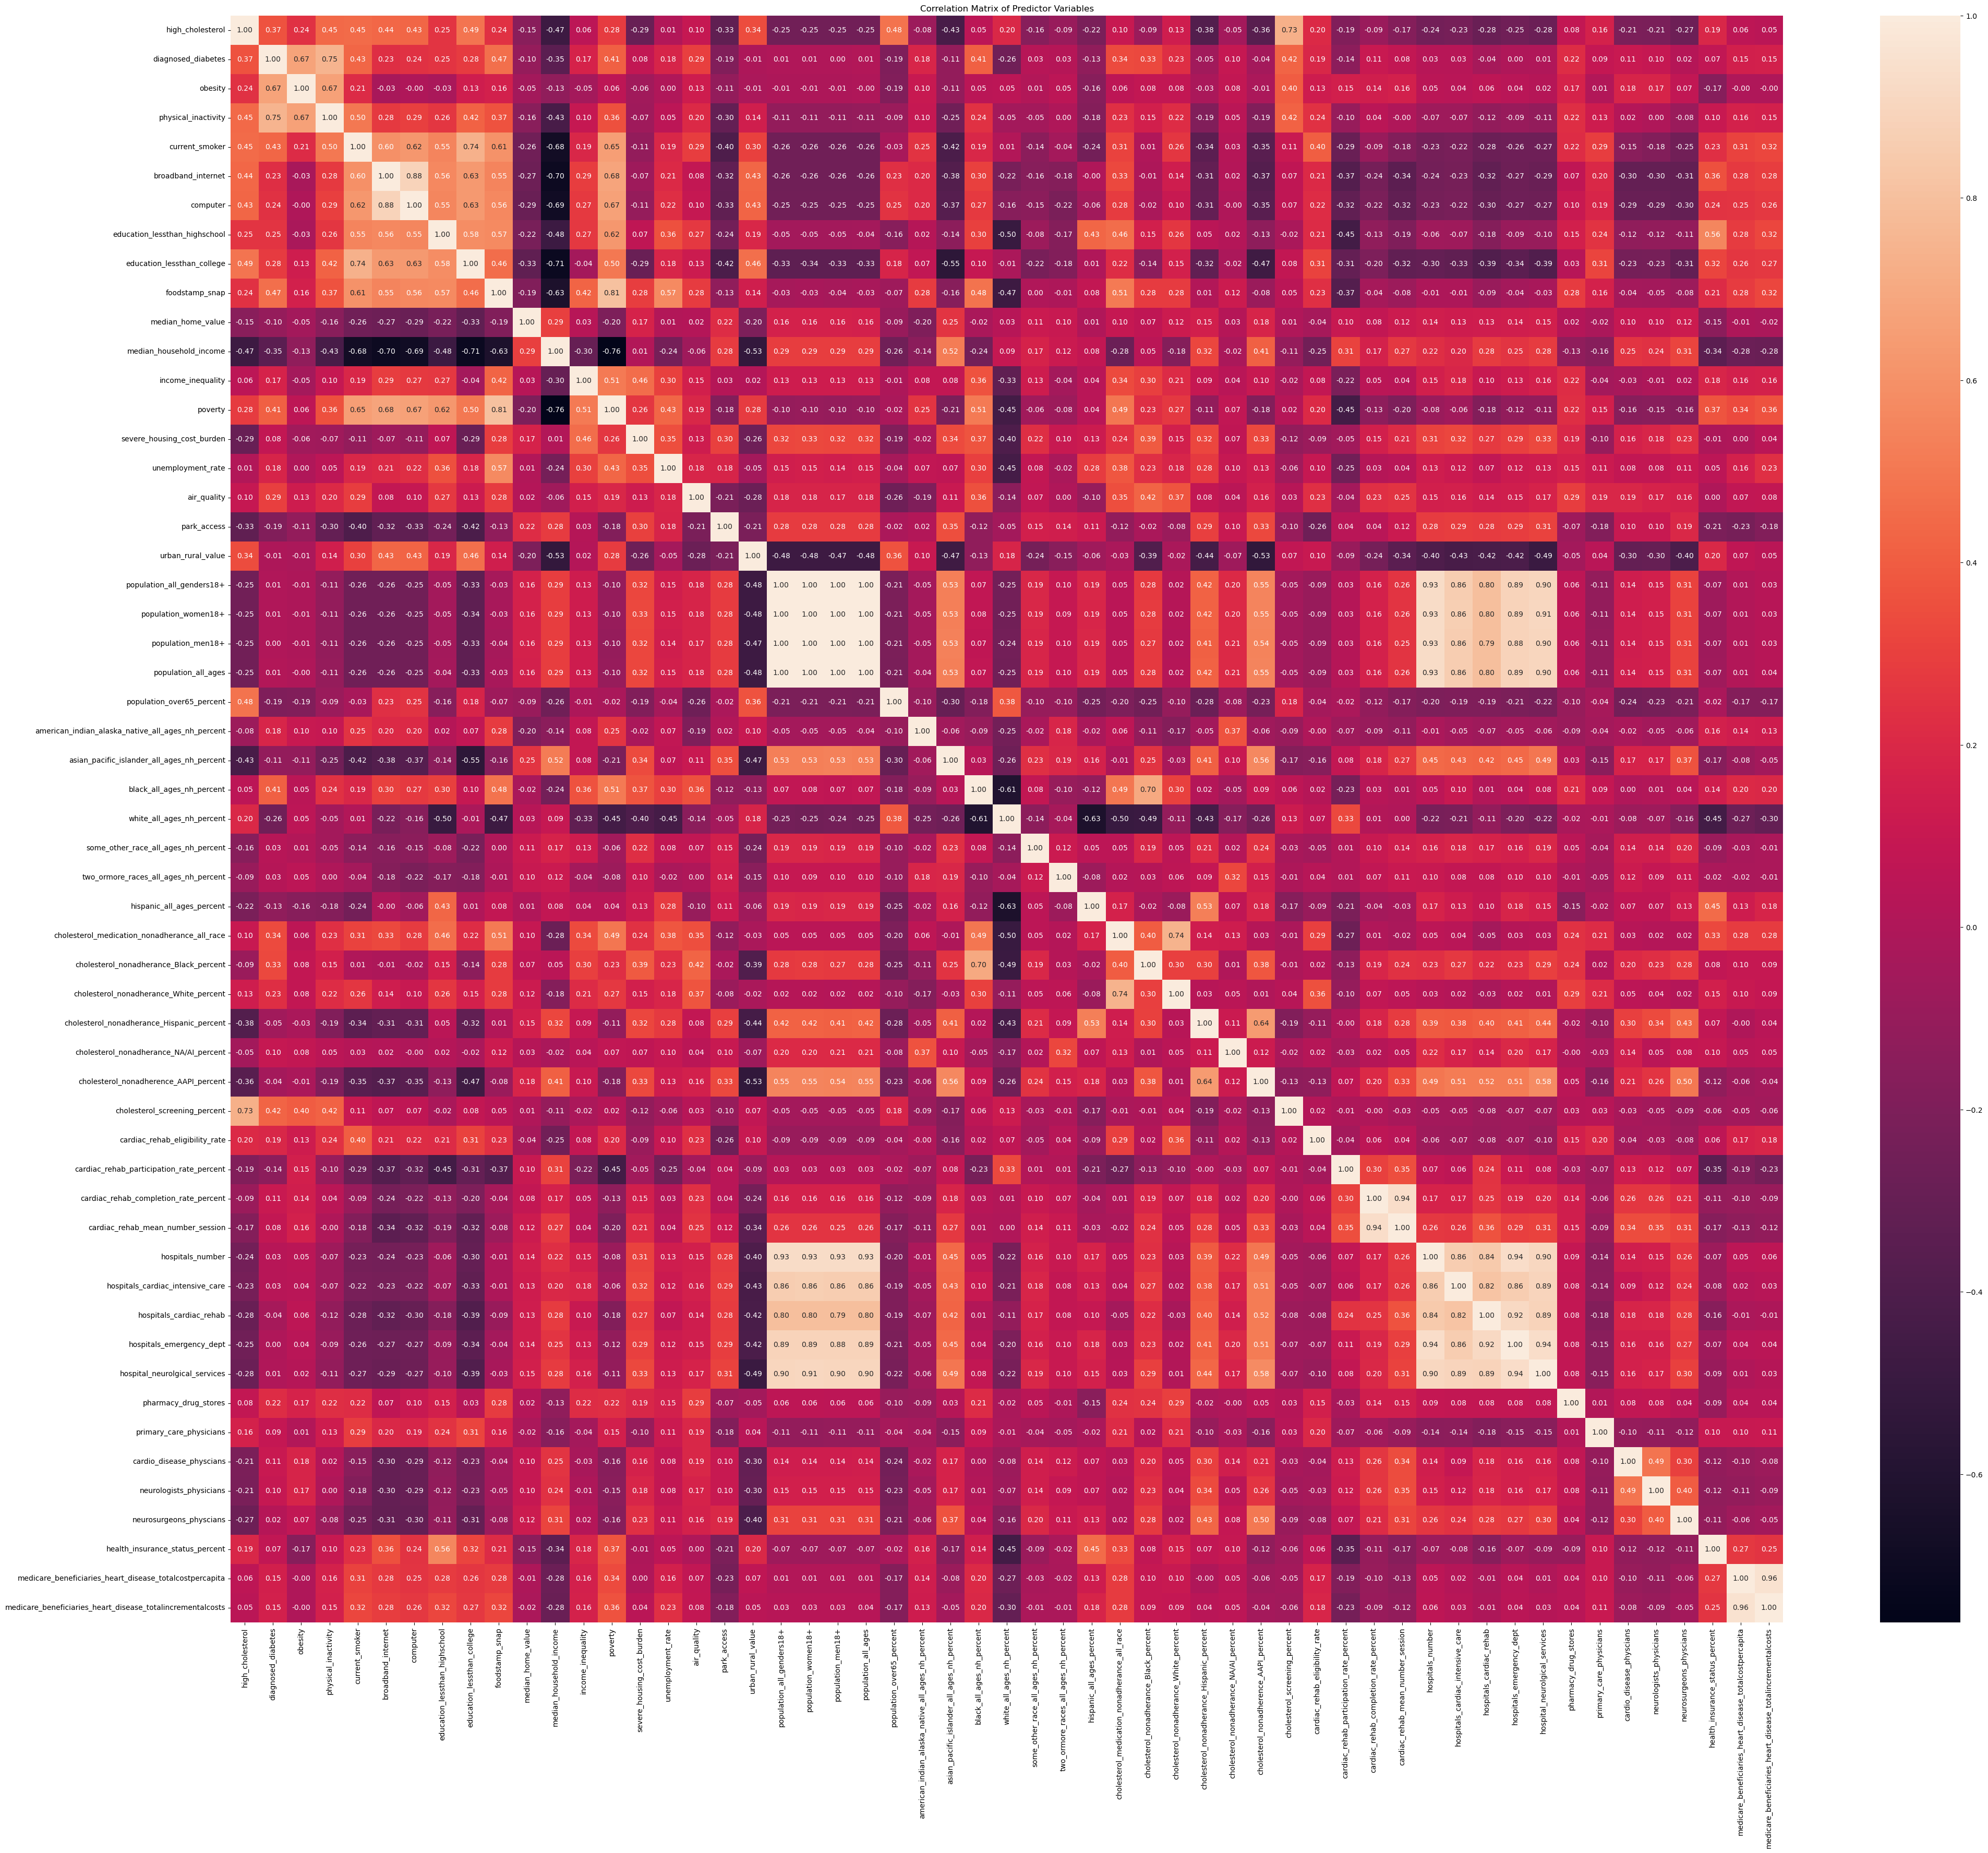

In [10]:
import seaborn as sns

# Calculating the correlation matrix for predictor variables
correlation_matrix = US.iloc[:, 3:58].corr()

# Plotting the correlation matrix
plt.figure(figsize=(48, 40))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Predictor Variables")
plt.show()

### State-Level Train-Test-Split

In [11]:
# Creating a dictionary to hold data for each state
state_data = {}
for state in US['State'].unique():
    state_data[state] = US[US['State'] == state]

In [12]:
from sklearn.model_selection import train_test_split

# Dictionary to store train-test data for each state
state_train_test_data = {}
minimum_sample_size = 5  # Set a minimum sample size for train-test split

for state, data in state_data.items():
    X = data.iloc[:, 3:58]  # Predictor variables
    y = data.iloc[:, 2]  # Target variable

    # Checking if the state has enough data for splitting
    if len(data) >= minimum_sample_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=153)
        state_train_test_data[state] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    else:
        print(f"Not enough data for state {state} (samples: {len(data)}). Skipping this state.")

Not enough data for state DE (samples: 3). Skipping this state.
Not enough data for state DC (samples: 1). Skipping this state.


### Aggregating State-level Train-Test-Split

In [13]:
# Initializing empty DataFrames for aggregated training and testing data
aggregated_train_X = pd.DataFrame()
aggregated_train_y = pd.Series(dtype='float')
aggregated_test_X = pd.DataFrame()
aggregated_test_y = pd.Series(dtype='float')

# Looping through each state's data and aggregate
for state_data in state_train_test_data.values():
    aggregated_train_X = pd.concat([aggregated_train_X, state_data['X_train']])
    aggregated_train_y = pd.concat([aggregated_train_y, state_data['y_train']])
    aggregated_test_X = pd.concat([aggregated_test_X, state_data['X_test']])
    aggregated_test_y = pd.concat([aggregated_test_y, state_data['y_test']])
    
# Adding DC and DE data to the test set
for state in ['DC', 'DE']:
    if state in state_data:
        aggregated_test_X = pd.concat([aggregated_test_X, state_data[state].iloc[:, 3:58]])
        aggregated_test_y = pd.concat([aggregated_test_y, state_data[state].iloc[:, 2]])    

## Model #1a -> XGBoost Model Trained on State Data

In [14]:
from xgboost import XGBRegressor

# Dictionary to store the models for each state
state_models = {}

for state, data in state_train_test_data.items():
    X_train, y_train = data['X_train'], data['y_train']

    model = XGBRegressor()
    model.fit(X_train, y_train)

    state_models[state] = model

    print(f"Trained model for state: {state}")

Trained model for state: CA
Trained model for state: OR
Trained model for state: WA
Trained model for state: AZ
Trained model for state: CO
Trained model for state: ID
Trained model for state: NV
Trained model for state: NM
Trained model for state: UT
Trained model for state: WY
Trained model for state: LA
Trained model for state: TX
Trained model for state: AR
Trained model for state: IA
Trained model for state: KS
Trained model for state: MN
Trained model for state: MO
Trained model for state: NE
Trained model for state: OK
Trained model for state: SD
Trained model for state: MT
Trained model for state: ND
Trained model for state: AL
Trained model for state: FL
Trained model for state: GA
Trained model for state: MS
Trained model for state: IL
Trained model for state: IN
Trained model for state: KY
Trained model for state: TN
Trained model for state: WI
Trained model for state: NC
Trained model for state: SC
Trained model for state: VA
Trained model for state: WV
Trained model for st

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dictionary to store evaluation metrics for each state
state_evaluation_metrics = {}

for state, data in state_train_test_data.items():
    X_test, y_test = data['X_test'], data['y_test']
    model = state_models[state]

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)

    state_evaluation_metrics[state] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(f"Evaluation for state {state} - MSE: {mse}, MAE: {mae}, R2: {r2}")

Evaluation for state CA - MSE: 0.6200872034549793, MAE: 0.6133211453755697, R2: 0.7188078812863581
Evaluation for state OR - MSE: 0.1528349707538756, MAE: 0.3147193312644956, R2: 0.8483027585569474
Evaluation for state WA - MSE: 1.0195470281656185, MAE: 0.750502109527588, R2: 0.42050612963943534
Evaluation for state AZ - MSE: 0.3856611205192528, MAE: 0.5936012903849281, R2: 0.7531329954001937
Evaluation for state CO - MSE: 0.6645035722001781, MAE: 0.6678210625281701, R2: 0.6895701467773383
Evaluation for state ID - MSE: 1.3020571266077714, MAE: 1.0349173439873594, R2: 0.5227754422840294
Evaluation for state NV - MSE: 2.115835154561285, MAE: 1.057398819923401, R2: 0.5774140248036381
Evaluation for state NM - MSE: 0.42431830777328805, MAE: 0.5700007574898859, R2: 0.8050665940287727


/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

Evaluation for state UT - MSE: 0.6089913717353571, MAE: 0.7032939434051513, R2: 0.6777823429971654
Evaluation for state WY - MSE: 0.23513004473445281, MAE: 0.41754636764526365, R2: 0.8049684433191333
Evaluation for state LA - MSE: 0.9244434693066375, MAE: 0.5271374335655798, R2: 0.7262276201015986
Evaluation for state TX - MSE: 0.7869127150431784, MAE: 0.563323206060073, R2: 0.6977247729602067
Evaluation for state AR - MSE: 0.35367165450193466, MAE: 0.48927673339843736, R2: 0.7241728864369661
Evaluation for state IA - MSE: 0.2393349758846297, MAE: 0.3731884098052978, R2: 0.5715449769340679
Evaluation for state KS - MSE: 0.29601406344074405, MAE: 0.42453086943853485, R2: 0.8015593427317158
Evaluation for state MN - MSE: 0.24415314224548806, MAE: 0.37996500333150246, R2: 0.8597617038584277
Evaluation for state MO - MSE: 0.4053352922684324, MAE: 0.4934930676999301, R2: 0.8032280723043033
Evaluation for state NE - MSE: 0.4153314219031802, MAE: 0.4178902676230982, R2: 0.7459165509116285


/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

Evaluation for state OK - MSE: 0.28423380000713105, MAE: 0.4121246814727783, R2: 0.8601448204777705
Evaluation for state SD - MSE: 0.59487511663231, MAE: 0.6468105588640487, R2: 0.4105383070781965
Evaluation for state MT - MSE: 0.8045136309225169, MAE: 0.7344411373138428, R2: 0.13077758963953745
Evaluation for state ND - MSE: 1.0187427969819163, MAE: 0.6336492191661488, R2: 0.5283959046797311
Evaluation for state AL - MSE: 0.32680505662674225, MAE: 0.4405187061854773, R2: 0.7226268085617223
Evaluation for state FL - MSE: 0.6340685008770863, MAE: 0.6625908715384349, R2: 0.7543972922038914
Evaluation for state GA - MSE: 0.3120521001349579, MAE: 0.4294639110565185, R2: 0.858439648365202
Evaluation for state MS - MSE: 0.2334302818383329, MAE: 0.35367107952342314, R2: 0.8140638568676528
Evaluation for state IL - MSE: 0.1520109014523726, MAE: 0.29752251761300225, R2: 0.8600308858301744
Evaluation for state IN - MSE: 0.19843632198411615, MAE: 0.36351584384315894, R2: 0.8539779195314405


/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

Evaluation for state KY - MSE: 0.5246885418020192, MAE: 0.5623308618863425, R2: 0.7673203630248115
Evaluation for state TN - MSE: 0.41484071499171093, MAE: 0.44537328418932454, R2: 0.8373509371679217
Evaluation for state WI - MSE: 0.0750815103043012, MAE: 0.23152773539225274, R2: 0.9334541092788633
Evaluation for state NC - MSE: 0.17478988475998003, MAE: 0.361399908065796, R2: 0.8941869785788997
Evaluation for state SC - MSE: 0.5593261278267705, MAE: 0.5851889419555661, R2: 0.6196095430993127
Evaluation for state VA - MSE: 0.43571224205212566, MAE: 0.5311410480075415, R2: 0.7415590831413139
Evaluation for state WV - MSE: 0.2892626234288365, MAE: 0.39669643748890254, R2: 0.497115266740097
Evaluation for state MI - MSE: 0.21127370355489333, MAE: 0.32072051553165204, R2: 0.9385424254379827
Evaluation for state OH - MSE: 0.43702435024582864, MAE: 0.4169759432474771, R2: 0.7450606048150943
Evaluation for state MD - MSE: 1.1959769081692886, MAE: 0.8219275093078611, R2: -0.3383806044866695
Ev

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

Evaluation for state NY - MSE: 0.15899854684317066, MAE: 0.3206775298485389, R2: 0.7583130561567204
Evaluation for state PA - MSE: 0.14925981239582414, MAE: 0.2998385565621514, R2: 0.8163302157861532
Evaluation for state CT - MSE: 0.25009628401993245, MAE: 0.4005458354949951, R2: 0.5553843839645645
Evaluation for state ME - MSE: 0.20497887575883397, MAE: 0.38331608772277814, R2: 0.5023274640149711
Evaluation for state MA - MSE: 0.3901504217085889, MAE: 0.559347184499105, R2: -0.5675686586505795
Evaluation for state NH - MSE: 1.130203467845972, MAE: 1.0155959606170653, R2: -0.02512786199181183
Evaluation for state RI - MSE: 0.08977440683419434, MAE: 0.29962377548217756, R2: nan
Evaluation for state VT - MSE: 0.6568477977339959, MAE: 0.5210096359252928, R2: -1.6628964772999844


/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

## Model #1b -> XGBoost Trained on Aggregated Continental Data  

In [16]:
import xgboost as xgb

# Creating the continental the XGBoost model
continental_model = xgb.XGBRegressor()

# Training the model
continental_model.fit(aggregated_train_X, aggregated_train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
# Making predictions on the aggregated test data
aggregated_test_predictions = continental_model.predict(aggregated_test_X)

# Calculating evaluation metrics
mse = mean_squared_error(aggregated_test_y, aggregated_test_predictions)
mae = mean_absolute_error(aggregated_test_y, aggregated_test_predictions)
r2 = r2_score(aggregated_test_y, aggregated_test_predictions)

print(f"XGB Continental Model - Mean Squared Error: {mse}")
print(f"XGB Continental Model - Mean Absolute Error: {mae}")
print(f"XGB Continental Model - R2 Score: {r2}")

XGB Continental Model - Mean Squared Error: 0.22599908313865788
XGB Continental Model - Mean Absolute Error: 0.33754508009524925
XGB Continental Model - R2 Score: 0.9010673543577028


/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

## Model #1c -> XGBoost Continental Model Predicting Heart Disease on State Data

In [18]:
#Testing continental model on each state to produce MSE per state to add to heat map above, to compare state-specific model performance vs continental model performance in each state
continental_model_mse = {}

for state, data in state_train_test_data.items():
    X_test, y_test = data['X_test'], data['y_test']

    # Making predictions using the continental model
    y_pred_continental = continental_model.predict(X_test)

    # Calculating MSE for the continental model on this state's test data
    mse_continental = mean_squared_error(y_test, y_pred_continental)
    continental_model_mse[state] = mse_continental

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

## Model #1 -> Visualization of Results

- Feature Importance for the Model
- Correlation Matrix between features
- Heatmap of error created by State Models and Continental Model tested at State level

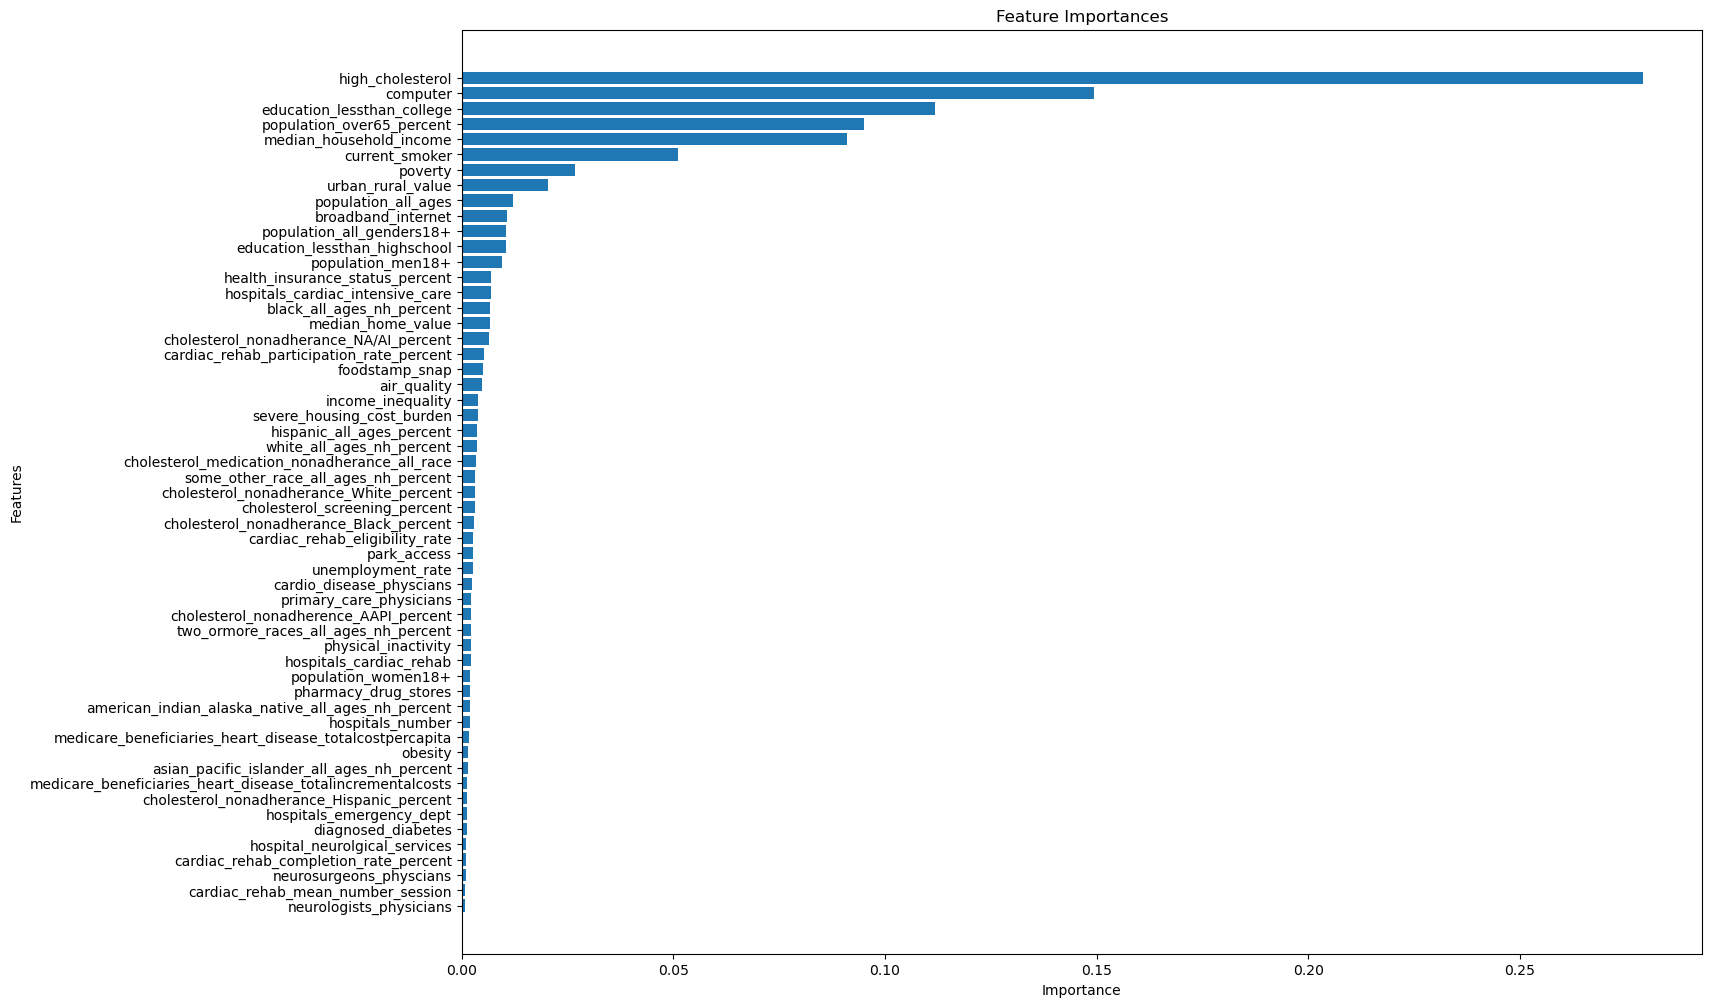

In [19]:
feature_importances = continental_model.feature_importances_
feature_names = US.columns[3:58]
importances = dict(zip(feature_names, feature_importances))

# Sorting by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Printing sorted feature importances
#for feature, importance in sorted_importances:
    #print(f"Feature: {feature}, Importance: {importance}")
    
# Unzipping the feature names and their importances
features, importances = zip(*sorted_importances)

# Creating bar chart
plt.figure(figsize=(16, 12))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Inverting the y-axis to show the most important feature at the top
plt.show()    

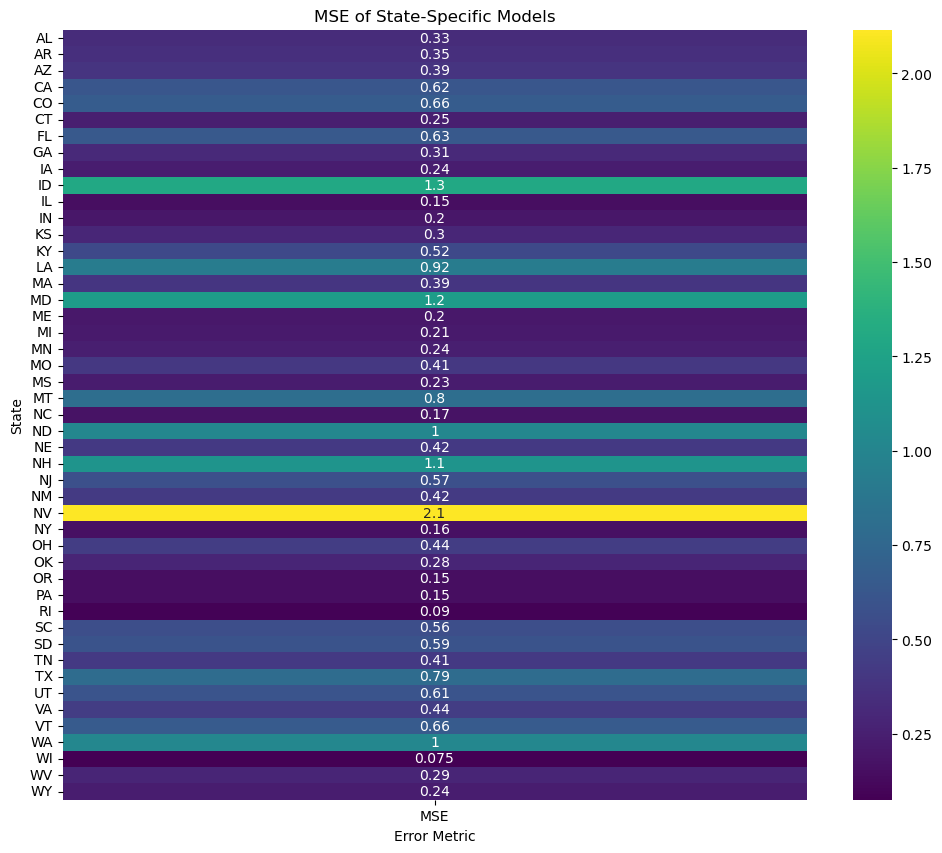

In [20]:
#Heatmap for State Model MSE 

mse_values = {state: metrics['MSE'] for state, metrics in state_evaluation_metrics.items()}
mse_df = pd.DataFrame(mse_values, index=['MSE']).T

# Plotting heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(mse_df.sort_index(), annot=True, cmap='viridis')
plt.title('MSE of State-Specific Models')
plt.xlabel('Error Metric')
plt.ylabel('State')
plt.show()

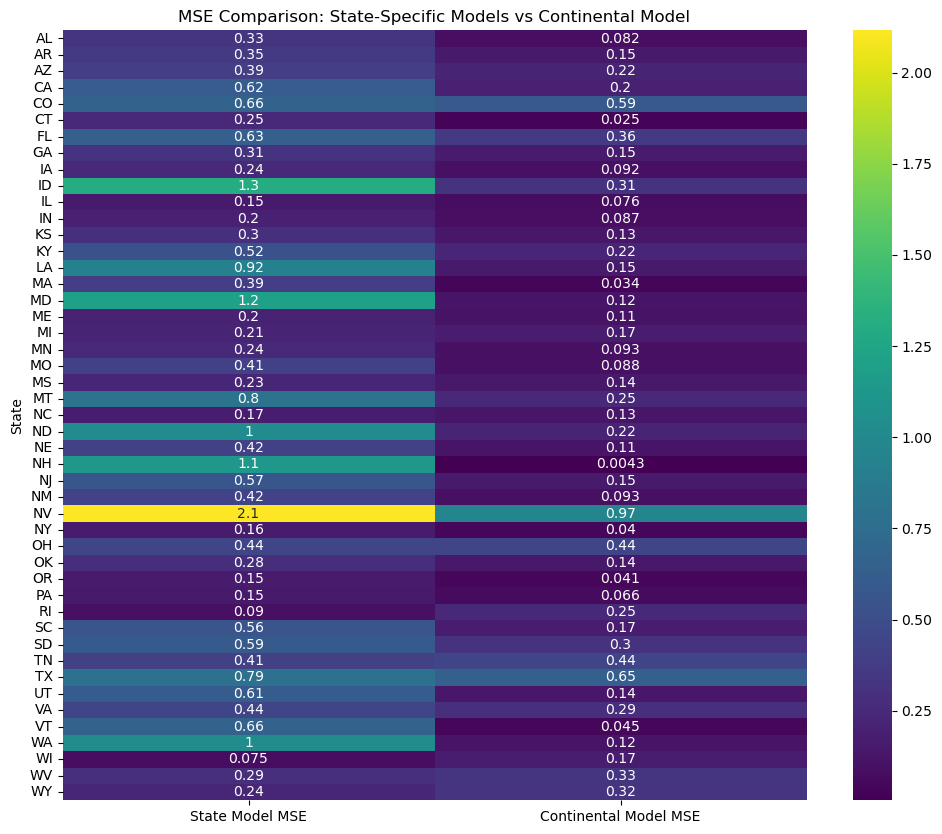

In [21]:
# Plotting heatmap to Compare

mse_comparison_df = pd.DataFrame({
    'State Model MSE': {state: metrics['MSE'] for state, metrics in state_evaluation_metrics.items()},
    'Continental Model MSE': continental_model_mse
})

plt.figure(figsize=(12, 10))
sns.heatmap(mse_comparison_df.sort_index(), annot=True, cmap='viridis')
plt.title('MSE Comparison: State-Specific Models vs Continental Model')
plt.ylabel('State')
plt.show()

## Model #2 -> Gaussian Naive Bayes Model

*Heart Disease variable must be discretized before performing Naive Bayes.

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer

## Model #2a -> Gaussian Naive Bayes State Models

In [23]:
# Initializing discretizer
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Binning the target variable for each state's training and testing data
for state, data in state_train_test_data.items():
    # Transforming the target variable
    data['y_train_binned'] = discretizer.fit_transform(data['y_train'].values.reshape(-1, 1)).flatten()
    data['y_test_binned'] = discretizer.transform(data['y_test'].values.reshape(-1, 1)).flatten()


In [24]:
# Dictionary to store the models for each state
state_models_gnb = {}

for state, data in state_train_test_data.items():
    # Initializing and training the Gaussian Naive Bayes model
    gnb = GaussianNB()
    gnb.fit(data['X_train'], data['y_train_binned'])

    # Storing the trained model
    state_models_gnb[state] = gnb


/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

In [25]:
# Dictionary to store evaluation metrics for each state
state_evaluation_metrics_gnb = {}

for state, data in state_train_test_data.items():
    # Retrieving the test data
    X_test, y_test_binned = data['X_test'], data['y_test_binned']
    model = state_models_gnb[state]

    # Making predictions
    y_pred_binned = model.predict(X_test)

    # Computing evaluation metrics
    mse = mean_squared_error(y_test_binned, y_pred_binned)
    mae = mean_absolute_error(y_test_binned, y_pred_binned)
    r2 = r2_score(y_test_binned, y_pred_binned)

    # Storing the metrics
    state_evaluation_metrics_gnb[state] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Printing state-specific metrics
for state, metrics in state_evaluation_metrics_gnb.items():
    print(f"State: {state}, MSE: {metrics['MSE']}, MAE: {metrics['MAE']}, R2: {metrics['R2']}")


/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

State: CA, MSE: 1.0833333333333333, MAE: 0.5833333333333334, R2: 0.7997432605905006
State: OR, MSE: 1.125, MAE: 0.875, R2: 0.48571428571428577
State: WA, MSE: 1.875, MAE: 1.125, R2: 0.6417910447761195
State: AZ, MSE: 2.0, MAE: 1.3333333333333333, R2: 0.0
State: CO, MSE: 2.8461538461538463, MAE: 1.3076923076923077, R2: 0.5658844765342961
State: ID, MSE: 3.6666666666666665, MAE: 1.6666666666666667, R2: 0.44999999999999996
State: NV, MSE: 16.25, MAE: 3.25, R2: -1.2608695652173911
State: NM, MSE: 1.0, MAE: 0.7142857142857143, R2: 0.5288461538461539
State: UT, MSE: 0.3333333333333333, MAE: 0.3333333333333333, R2: 0.9090909090909091
State: WY, MSE: 9.8, MAE: 3.0, R2: -1.3113207547169812
State: LA, MSE: 3.923076923076923, MAE: 1.6153846153846154, R2: 0.5711513583441139
State: TX, MSE: 6.196078431372549, MAE: 1.6470588235294117, R2: -0.9199428162973549
State: AR, MSE: 1.7333333333333334, MAE: 0.8, R2: 0.4772117962466488
State: IA, MSE: 1.75, MAE: 1.15, R2: 0.33712121212121227
State: KS, MSE: 1

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

## Model #2b -> Gaussian Naive Bayes Continental Model

In [26]:
# Discretizing the target variable into bins
number_of_bins = 10
y_train_continental_binned = pd.qcut(aggregated_train_y, q=number_of_bins, labels=False, duplicates='drop')
y_test_continental_binned = pd.qcut(aggregated_test_y, q=number_of_bins, labels=False, duplicates='drop')

# Training the Gaussian Naive Bayes model with the binned target
gnb_continental = GaussianNB()
gnb_continental.fit(aggregated_train_X, y_train_continental_binned)

# Evaluating the model with the binned target
y_pred_continental = gnb_continental.predict(aggregated_test_X)
mse_continental = mean_squared_error(y_test_continental_binned, y_pred_continental)
mae_continental = mean_absolute_error(y_test_continental_binned, y_pred_continental)
r2_continental = r2_score(y_test_continental_binned, y_pred_continental)

print("GNB Continental Model - Mean Squared Error:", mse_continental)
print("GNB Continental Model - Mean Absolute Error:", mae_continental)
print("GNB Continental Model - R2 Score:", r2_continental)

GNB Continental Model - Mean Squared Error: 5.440438871473354
GNB Continental Model - Mean Absolute Error: 1.6661442006269593
GNB Continental Model - R2 Score: 0.3376186013734592


/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

## Model #3 -> Linear Regression (Lasso CV)

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from IPython.display import display

In [28]:
#Defining a data frame for Lasso CV model
heart_cal = US[US.iloc[:, 1].str.contains("\(CA\)")]
cols_to_drop = ['cnty_fips','display_name', 'State', 'heart_disease','StateFN']
heart_cal_numeric = heart_cal.drop(columns=cols_to_drop)

## Model #3a -> Linear Regression (Lasso CV) Continental Model

In [29]:
#replacing -1 with NaN and imputing mean

aggregated_train_X[aggregated_train_X == -1] = np.nan
means = aggregated_train_X.mean(skipna=True)
agg_X_train_imputed = aggregated_train_X.apply(lambda col: col.fillna(means[col.name])
                                    if not pd.isna(means[col.name]) else col.fillna(0) )

aggregated_test_X[aggregated_test_X==-1] = np.nan
agg_X_test_imputed = aggregated_test_X.apply(lambda col: col.fillna(means[col.name])
                                    if not pd.isna(means[col.name]) else col.fillna(0) )

In [30]:
#Scaling X
scaler = StandardScaler()
agg_X_train_normalized = scaler.fit_transform(agg_X_train_imputed)
agg_X_test_normalized = scaler.transform(agg_X_test_imputed)

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

In [31]:
#imputing y values

aggregated_train_y[aggregated_train_y==-1] = np.nan
mean_agg_y_train = aggregated_train_y.mean(skipna=True)
agg_y_train_imputed = aggregated_train_y.fillna(mean_agg_y_train)

aggregated_test_y[aggregated_test_y == -1] =np.nan
agg_y_test_imputed = aggregated_test_y.fillna(mean_agg_y_train)

In [32]:
#Fit linear regression model
model = LassoCV(max_iter=10000000)
model.fit(agg_X_train_normalized, agg_y_train_imputed)
agg_y_pred = model.predict(agg_X_test_normalized)

#Error and Features
agg_mse = mean_squared_error(agg_y_test_imputed, agg_y_pred)
agg_mae = mean_absolute_error(agg_y_test_imputed, agg_y_pred)
agg_r2 = r2_score(agg_y_test_imputed, agg_y_pred)

agg_coefficients = model.coef_
agg_feature_importance = np.abs(agg_coefficients)

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

In [33]:
print("Error Metrics: ")
print("LR Continental Model - Mean Squared Error:", agg_mse)
print("LR Continental Model - Mean Absolute Error:", agg_mae)
print("LR Continental Model - R2 Score:", agg_r2)

#print("Regression Results: ")
#print("coefficients", (agg_coefficients))
#print("US wide predicted heart disease percentage", agg_y_pred)

Error Metrics: 
LR Continental Model - Mean Squared Error: 0.27941093684100143
LR Continental Model - Mean Absolute Error: 0.32227076937333154
LR Continental Model - R2 Score: 0.8776859497871801


## Model #3a -> Lasso CV Importance Features Continental Model 

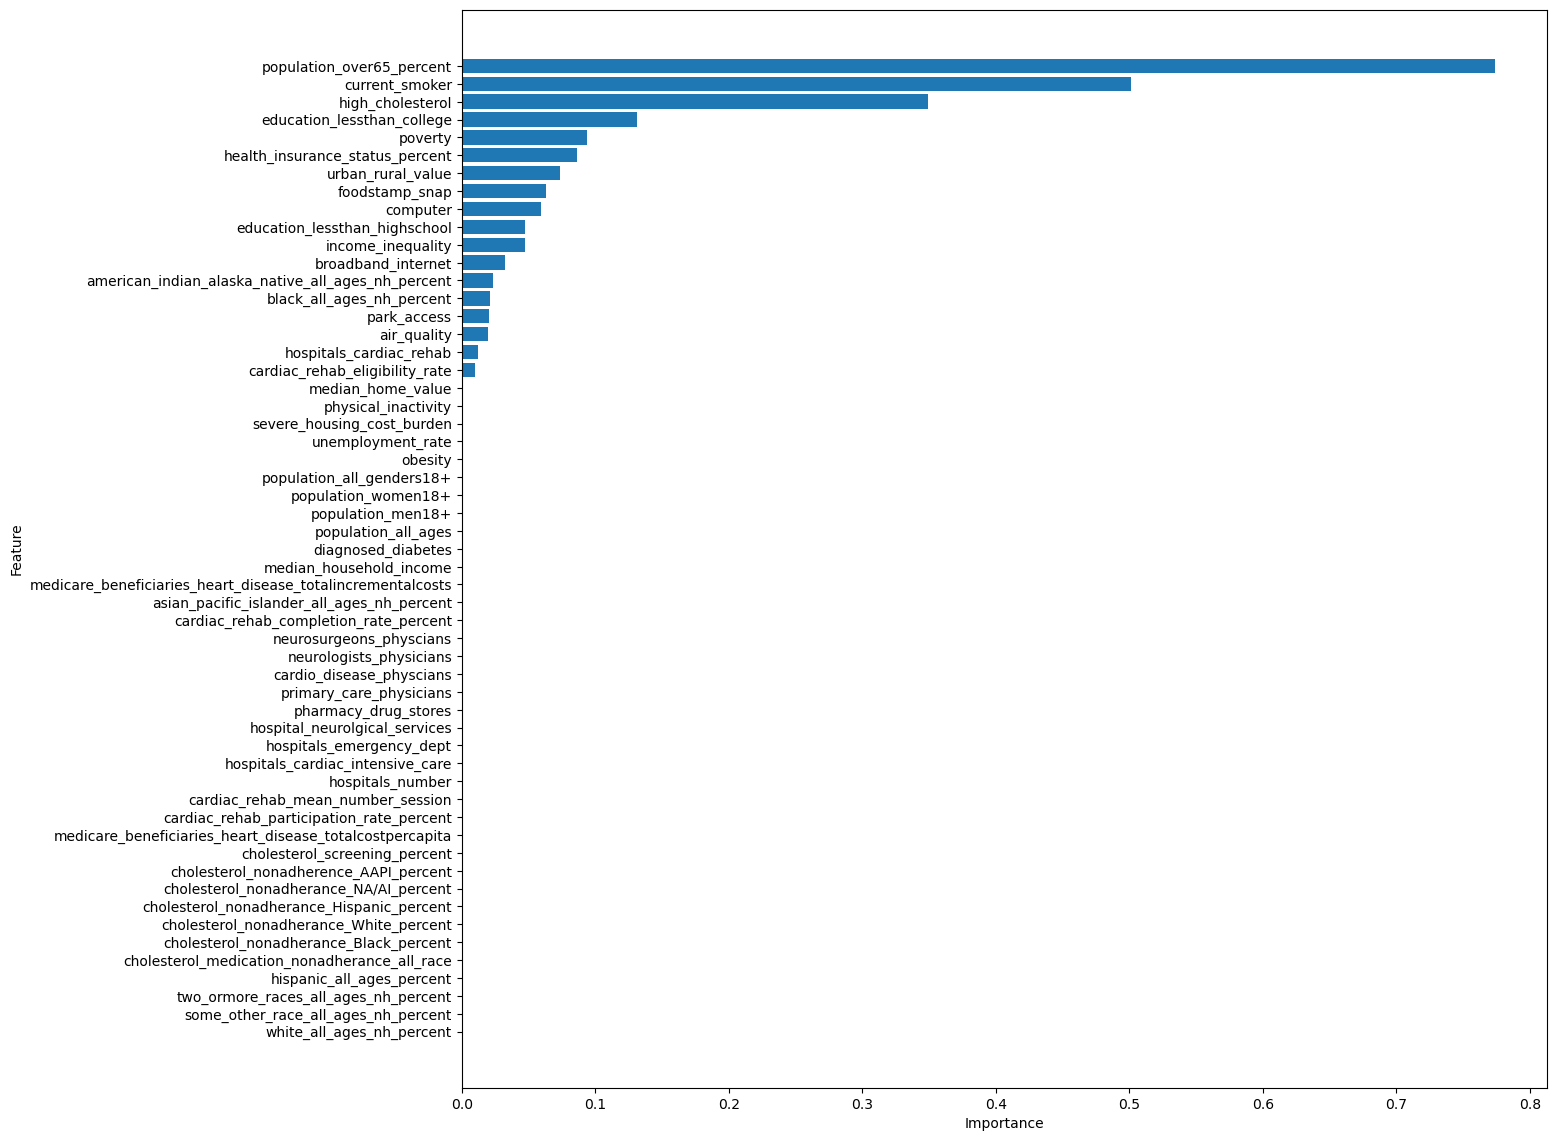

In [34]:
agg_feature_importance_df = pd.DataFrame({'Feature': aggregated_train_X.columns, 'Importance': agg_feature_importance})
agg_feature_importance_df = agg_feature_importance_df.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(14, 14))
plt.barh(agg_feature_importance_df['Feature'], agg_feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(ha='right')
plt.show()

## Model #3b -> Lasso CV State Models

In [35]:
states = {"Alabama":"AL","Kentucky":"KY","Ohio":"OH",
"Louisiana":"LA","Oklahoma":"OK",
"Arizona":"AZ","Maine":"ME","Oregon":"OR",
"Arkansas":"AR","Maryland":"MD","Pennsylvania":"PA",
"Massachusetts":"MA","California":"CA","Michigan":"MI","Rhode Island":"RI",
"Colorado":"CO","Minnesota":"MN","South Carolina":"SC",
"Connecticut":"CT","Mississippi":"MS","South Dakota":"SD",
"Delaware":"DE","Missouri":"MO","Tennessee":"TN",
"District of Columbia":"DC","Montana":"MT","Texas":"TX",
"Florida":"FL","Nebraska":"NE",
"Georgia":"GA","Nevada":"NV","Utah":"UT",
"New Hampshire":"NH","Vermont":"VT",
"New Jersey":"NJ","Virginia":"VA",
"Idaho":"ID","New Mexico":"NM",
"Illinois":"IL","New York":"NY","Washington":"WA",
"Indiana":"IN","North Carolina":"NC","West Virginia":"WV",
"Iowa":"IA","North Dakota":"ND","Wisconsin":"WI",
"Kansas":"KS","Wyoming":"WY"
}

In [36]:
small_states = []
raw_state_data = []
heart_array = []
agg_X_train = pd.DataFrame()
agg_X_test = pd.DataFrame()
agg_y_train = pd.Series()
agg_y_test = pd.Series()

for name,code in states.items():

    heart_st = US.loc[US['State'].str.contains(code)]
    heart_st_numeric = heart_st.drop(columns=['cnty_fips', 'State', 'display_name', 'heart_disease','StateFN'])

    #correlation matrix
    heart_st_corr = heart_st_numeric.corr
    X = heart_st_numeric.copy()
    X.index = [name]*len(X)
    y = heart_st['heart_disease'].copy()
    y.index = [name]*len(y)
    raw_state_data.append([name, code, X, y])

    if len(X)>=6:

        #train test split and aggregation

        X_train, X_test, y_train, y_test = train_test_split (X, y,
                                                             train_size=0.8, random_state =153)
        agg_X_train = agg_X_train._append(X_train)
        agg_X_test = agg_X_test._append(X_test)
        agg_y_train = agg_y_train._append(y_train)
        agg_y_test = agg_y_test._append(y_test)

        #Replace NaN values in X_train and X_test with the column-wise means or 0 if all values -1
        X_train[X_train == -1] = np.nan
        means = X_train.mean(skipna=True)
        X_train_imputed = X_train.apply(lambda col: col.fillna(means[col.name])
                                         if not pd.isna(means[col.name]) else col.fillna(0) )

        X_test[X_test==-1] = np.nan
        X_test_imputed = X_test.apply(lambda col: col.fillna(means[col.name])
                                      if not pd.isna(means[col.name]) else col.fillna(0) )

        #scaling X values to ensure convergence
        scaler = StandardScaler()
        X_train_normalized = scaler.fit_transform(X_train_imputed)
        X_test_normalized = scaler.transform(X_test_imputed)

        #imputing y values

        y_train[y_train==-1] = np.nan
        mean_y_train = y_train.mean(skipna=True)
        y_train_imputed = y_train.fillna(mean_y_train)

        y_test[y_test == -1] =np.nan
        y_test_imputed = y_test.fillna(mean_y_train)


        #training and prediction on test data, validation

        model_all = LassoCV(max_iter=10000000)
        model_all.fit(X_train_normalized, y_train_imputed)
        y_pred = model_all.predict(X_test_normalized)
        mse = mean_squared_error(y_test_imputed, y_pred)
        r2 = r2_score(y_test_imputed, y_pred)
        coefficients = model_all.coef_
        feature_importance = np.abs(coefficients)
        feature_importance_df = pd.DataFrame({'Feature': heart_cal_numeric.columns, 'Importance': feature_importance})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

        heart_array.append([name,code,heart_st_corr, y_pred, mse, r2, feature_importance_df])

    else:
        small_states.append(name)
        agg_X_test = agg_X_test._append(X)
        agg_y_test = agg_y_test._append(y)

/var/folders/8w/71g7ft8n6kxb6p_4zvxy8vlr0000gn/T/ipykernel_10094/188716768.py:30: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  agg_y_train = agg_y_train._append(y_train)
/var/folders/8w/71g7ft8n6kxb6p_4zvxy8vlr0000gn/T/ipykernel_10094/188716768.py:31: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  agg_y_test = agg_y_test._append(y_test)
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if 

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mking/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

## Model 3b - State-specific Lasso CV Model Error Heatmap

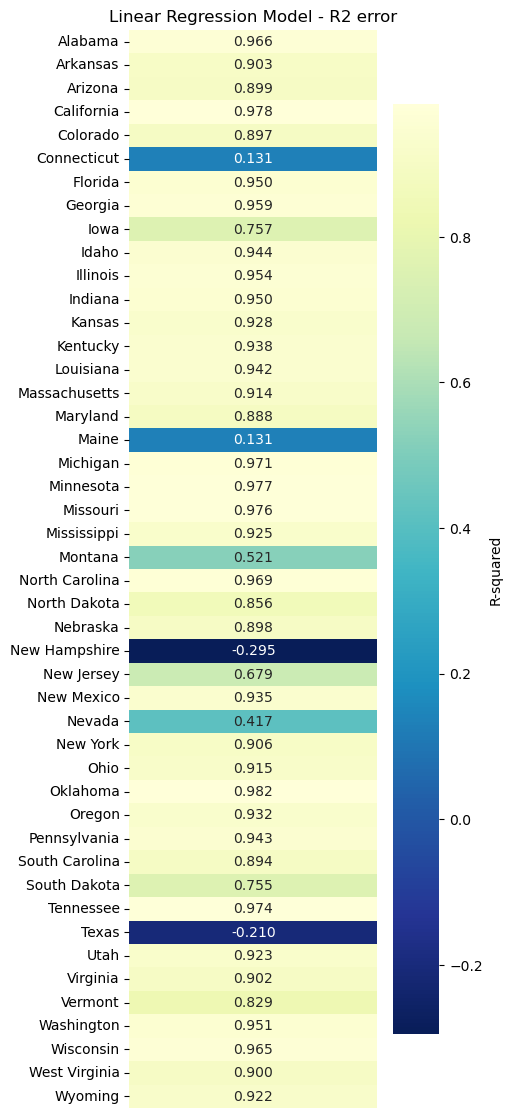

In [37]:
lasso_heart_array = sorted(heart_array, key=lambda x: x[1])

heatmap_r2 = pd.DataFrame([(row[5]) for row in lasso_heart_array])
plt.figure(figsize=(4, 14))
sns.heatmap(heatmap_r2, annot=True, cmap="YlGnBu_r", fmt='.3f', xticklabels=False,
            yticklabels=[row[0] for row in lasso_heart_array], cbar_kws={'label': 'R-squared'})
plt.title('Linear Regression Model - R2 error')
plt.show()

## R2 Comparison - XGBoost and Lasso CV

In [38]:
def data(state_code):
    result = list(filter(lambda x: state_code in x[1], heart_array))
    raw_data = list(filter(lambda x: state_code in x[1], raw_state_data))
    return raw_data

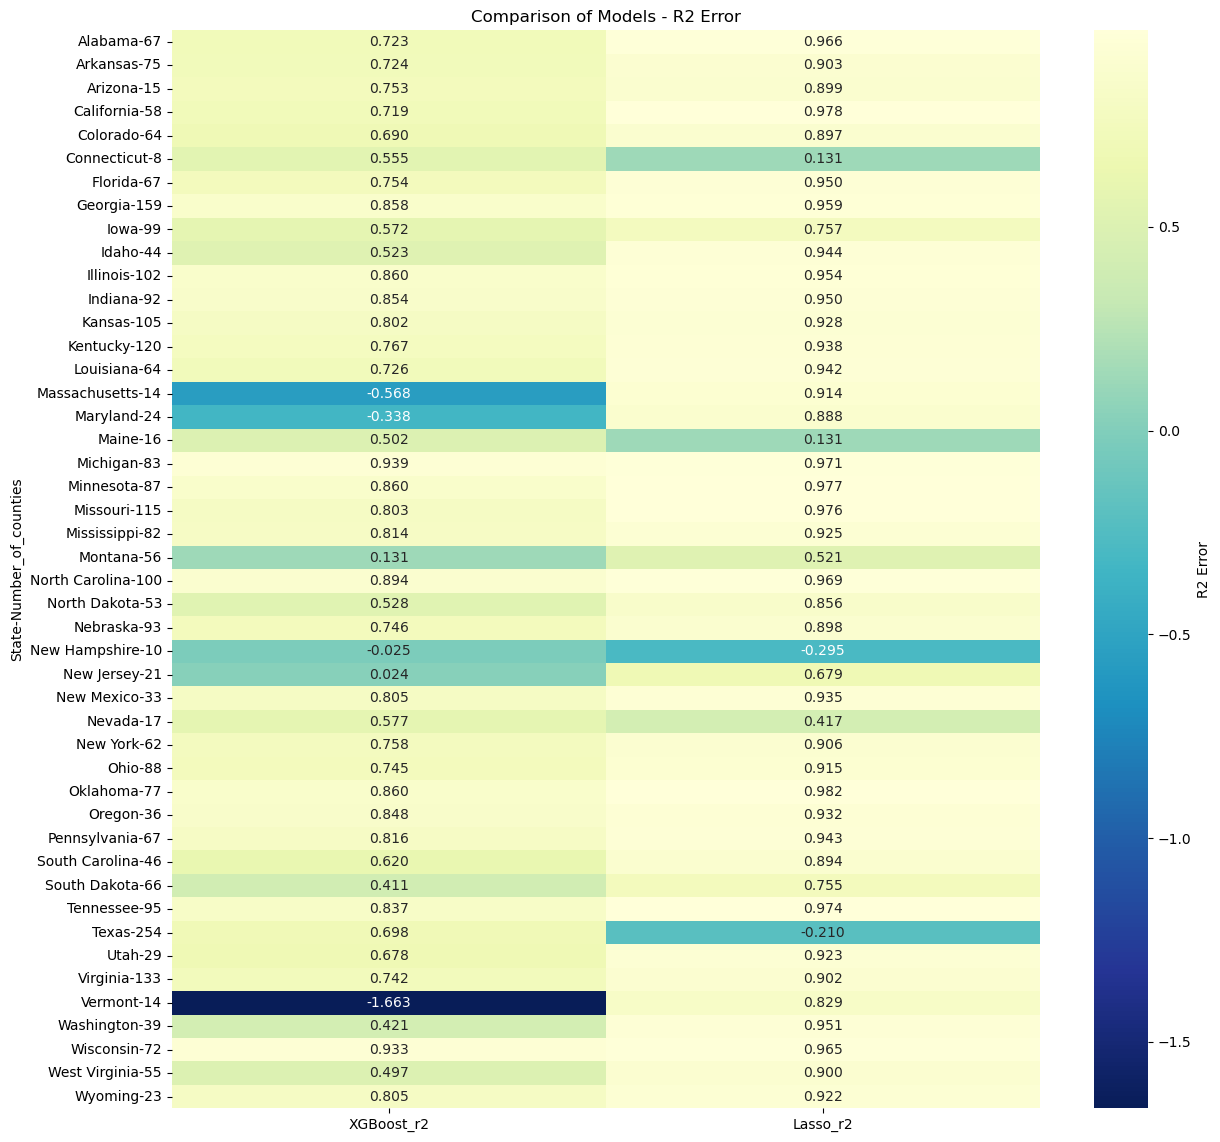

In [39]:
lasso_heart_array = sorted(heart_array, key=lambda x: x[1])

state_list = [row[0] for row in lasso_heart_array]
# Create a dictionary mapping full state names to abbreviations
state_fn_to_abbr = dict(zip(US['StateFN'], US['State']))

XGBoost_r2 = []

# Iterate through each full state name in state_list
for full_state_name in state_list:
    # Find the corresponding abbreviation
    state_abbr = state_fn_to_abbr.get(full_state_name, None)

    # Retrieve the R2 score for the abbreviation from state_evaluation_metrics
    r2_score = state_evaluation_metrics.get(state_abbr, {}).get('R2', None) if state_abbr else None
    XGBoost_r2.append(r2_score)


Lasso_r2 = [row[5] for row in lasso_heart_array]
no_of_counties = [len(data(row[1])[0][2]) for row in lasso_heart_array]

errors = pd.DataFrame({"State": state_list,"Number_of_counties":no_of_counties, "XGBoost_r2": XGBoost_r2, "Lasso_r2": Lasso_r2})

errors = errors.set_index(["State", "Number_of_counties"])



plt.figure(figsize=(14, 14))
sns.heatmap(errors, annot=True, cmap="YlGnBu_r", fmt=".3f", cbar_kws={'label': 'R2 Error'})
plt.title('Comparison of Models - R2 Error')
plt.show()